In [ ]:
# ===================================================================
# CELL 1: PROJECT SETUP (RUN THIS FIRST, EVERY TIME)
# ===================================================================

# This automatically reloads t .py files when you make changes
%load_ext autoreload
%autoreload 2

import sys
import os

# This block adds your project's root directory to Python's path
# It finds the path to this notebook and goes up one level ('..')
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Project root added to path: {project_root}")
else:
    print(f"Project root already in path: {project_root}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project root already in path: c:\Users\Mauricio\Desktop\Kaggle-datasets\Predicting-Optimal-Fertilizers


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from src.training import train_and_log_models
import src.evaluation as evl
import joblib

# Model Training and Evaluation

This notebook marks the beginning of the modeling phase. The primary objective is to train, tune, and evaluate a set of candidate models on the preprocessed data to establish a strong performance baseline.

Our methodology is designed to be both organized and flexible, allowing for easy experimentation. We will define a collection of powerful, probabilistic models suitable for this multi-class classification task. A configuration list will allow us to select which models to train in any given run, which is particularly useful for later stages like ensembling, where multiple models are required.

For each selected model, we will perform initial hyperparameter tuning using `RandomizedSearchCV` to find a robust set of parameters. The performance of every model will be rigorously measured against the competition's **MAP@3** metric, ensuring our optimization is directly aligned with the final goal. This iterative process of training, tuning, and evaluating will guide our subsequent efforts in feature engineering and model improvement.

## 1. Loading Data and Creating the Validation Set

This notebook is dedicated to the model training, evaluation, and prediction phase. It follows a two-notebook project structure that supports an iterative development cycle: insights gained from model performance here will inform subsequent rounds of feature engineering in the primary EDA notebook.

The first critical step is to load the preprocessed data and create a reliable validation set. This set—distinct from the final competition test data—is essential for measuring model performance accurately.

We will partition the data into an **80% training set** and a **5% validation set**. To ensure the distribution of the target variable (`Fertilizer Name`) is identical across both subsets, a stratified split will be performed. All subsequent model evaluation will be conducted on this validation set using the official competition metric, **MAP@3**.

In [3]:
pof_df_proc = pd.read_csv('../data/processed/pof_df_proc.csv')
pof_df_test_proc = pd.read_csv('../data/processed/pof_df_test_proc.csv')

if 'Fertilizer Name' in list(pof_df_proc):
    pof_train_fert = pof_df_proc['Fertilizer Name']
    pof_df_proc = pof_df_proc.drop('Fertilizer Name', axis=1)

test = pd.read_csv('../data/test.csv')
id_test = test['id']
del test

In [4]:
X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(
    pof_df_proc,
    pof_train_fert,
    test_size=0.05,
    stratify=pof_train_fert,
    random_state=42
)
print(f'Train sample has {X_train_split.shape[0]} rows while test sample has {X_test_split.shape[0]}')

Train sample has 712500 rows while test sample has 37500


# 2. Model training

This is were we begin to train our models. First of all we need to choose the model that will be trained. We need to write a list containing strings with the models we want to fit, simple as that. Then, we gonna check their performances.

In [5]:
# Models we can choose:
# RF -> Random Forest Classifier
# lgb -> Light Gradient Boost Machine
# xgb -> eXtreme Gradient Boosting

models_list = ['RF', 'lgb'] # models that will be used in this training

models = {
    'RF': RandomForestClassifier(random_state=42, n_jobs=-1),
    'lgb': lgb.LGBMClassifier(random_state=42, n_jobs=-1),
    'xgb': xgb.XGBClassifier(random_state=42, n_jobs=-1),
}

params = {
    'RF': {
        'n_estimators': [200, 400, 600, 800, 1000],
        'max_depth': [10, 20, 30, None],
        'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10]
    },
    'lgb': {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [500, 1000, 2000, 3000],
        'num_leaves': [31, 60, 90], #31 is default
        'max_depth': [5, 7, 10, -1],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'subsample': [0.7, 0.8, 0.9],
        'reg_alpha': [0.1, 1, 10],
        'reg_lambda': [0.1, 1, 10]
    },
    'xgb': {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [500, 1000, 2000],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'gamma': [0, 0.1, 0.5],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [1, 5, 10]
        }
}

In [6]:
fitted_models = train_and_log_models(
    X_train=X_train_split,
    y_train=Y_train_split,
    models_to_run=models_list,
    all_models=models,
    all_params=params,
    n_iter=15,
    cv=3
)

print("\n Workflow complete! The following models have been trained and logged to MLflow:")
for name, model in fitted_models.items():
    print(f"- {name}")

----- Starting Experiment for: RF -----


c:\Users\Mauricio\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Mauricio\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Mauricio\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\Users\Mauricio\anaconda3\lib\site-packages\joblib\parallel.py", line 1056, in __call__
    self.retrieve()
  File "c:\Users\Mauricio\anaconda3\lib\site-packages\joblib\par

Finished training for RF. Best CV Score: -1.9328
----- Starting Experiment for: lgb -----
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 712500, number of used features: 22
[LightGBM] [Info] Start training from score -1.884863
[LightGBM] [Info] Start training from score -1.880059
[LightGBM] [Info] Start training from score -1.897541
[LightGBM] [Info] Start training from score -1.911539
[LightGBM] [Info] Start training from score -1.909122
[LightGBM] [Info] Start training from score -2.067671
[LightGBM] [Info] Start training from score -2.094847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

2025/06/12 10:28:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/12 10:28:49 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Mauricio\AppData\Local\Temp\tmp9770ft_g\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/06/12 10:28:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Finished training for lgb. Best CV Score: -1.9153

 Workflow complete! The following models have been trained and logged to MLflow:
- RF
- lgb


## 3. Evaluation

After training the models is time to evaluate their performance. In this step we will also see which fertilizer the model predicted better and which features it used the most. These insights can be valuable to go back to the feature engineering or fine tuning the hyperparameters. Let's calculate the probabilities and see their score:

In [32]:
best_rf = fitted_models['RF']
y_pred_probabs_rf = best_rf.predict_proba(X_test_split)

In [27]:
best_lgb = fitted_models['lgb']
y_pred_probabs_lgb = best_lgb.predict_proba(X_test_split)

In [41]:
rf_score = evl.calculate_map3(Y_test_split, y_pred_probabs_rf)
print(f'The MAP@3 score for the Random Forest model is: {rf_score:.5f}')

The MAP@3 score for the Random Forest model is: 0.29216


In [42]:
lgb_score = evl.calculate_map3(Y_test_split, y_pred_probabs_lgb)
print(f'The MAP@3 score for the Light Gradient Boost model is: {lgb_score:.5f}')

The MAP@3 score for the Light Gradient Boost model is: 0.30930


That's not so bad considering that we did no feature engineering at all. The goal of this run is to have a base score to see if our changes are improving or not the model. Let's see the confusion matrix for these models:

In [46]:
artifacts = joblib.load('../models/preprocessors/preproc_artifacts.joblib')
target_encoder = artifacts['target_encoder']
class_names = target_encoder.classes_

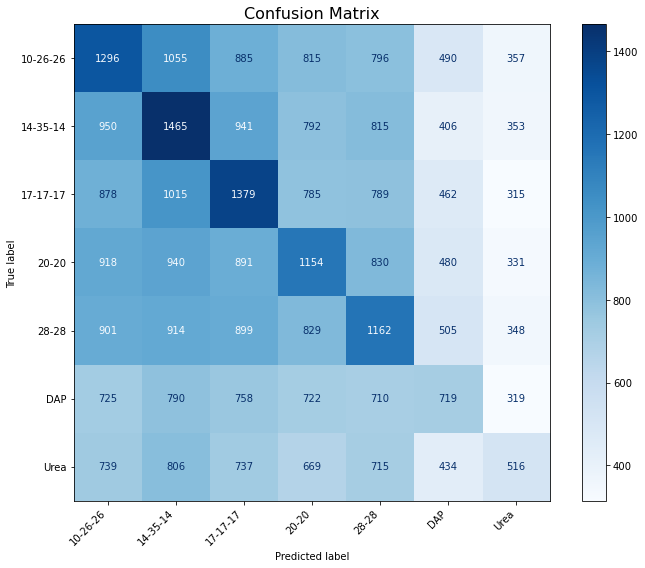

In [48]:
evl.plot_confusion_matrix(
    model=best_lgb,
    X_val=X_test_split,
    y_val=Y_test_split,
    class_names=class_names
)

### Light Gradient Boost - Confusion Matrix Analysis

The model demonstrates clear predictive power, as the values along the main diagonal (correct predictions) are the largest in each row. This indicates that the model is performing significantly better than random chance. However, the performance is not uniform across all classes. It predicts fertilizers like `14-35-14` and `10-26-26` with higher accuracy, while it struggles significantly with `DAP` and, most notably, `Urea`.

Key Confusion Patterns:
A strong pattern of confusion emerges among the top three NPK-labeled fertilizers (`10-26-26`, `14-35-14`, `17-17-17`), which are frequently mistaken for one another. For example, when the true label is `10-26-26`, the model incorrectly predicts `14-35-14` over 1,000 times.

The most critical issue is with Urea. The model incorrectly predicts `14-35-14` (806 times) far more often than it correctly predicts `Urea` (516 times). This suggests that in cases of uncertainty, the model may be defaulting to a more common or general-purpose fertilizer type.

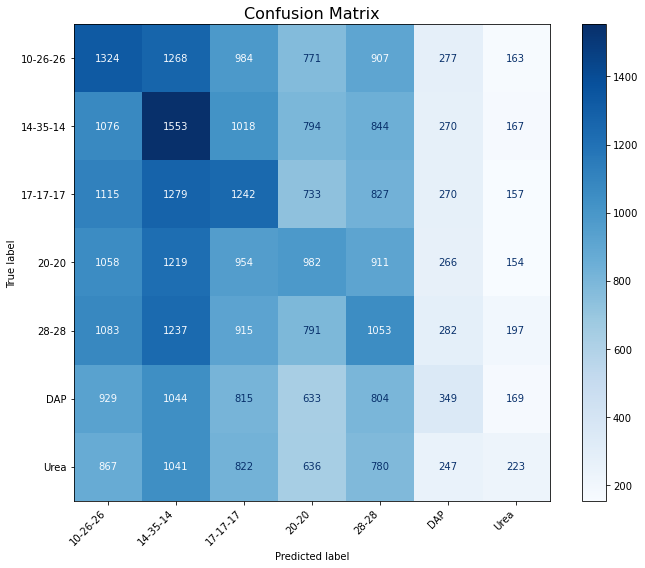

In [49]:
evl.plot_confusion_matrix(
    model=best_rf,
    X_val=X_test_split,
    y_val=Y_test_split,
    class_names=class_names
)

### Random Forest - Confusion Matrix Analysis

**Overall Performance:**
The Random Forest (RF) model displays similar but more extreme tendencies compared to the LightGBM model. It demonstrates strong predictive capability for the most common class, `14-35-14`, correctly identifying it more often than the LGBM model. However, this comes at a significant cost to its performance on other classes, particularly the less frequent ones like `DAP` and `Urea`.

**The "Dominant Error" Pattern:**
The most striking characteristic of the RF model is its overwhelming bias toward predicting `14-35-14`. For four of the seven classes (`20-20`, `28-28`, `DAP`, and `Urea`), the model's most frequent prediction is an incorrect guess of `14-35-14`.

The performance on `Urea` is particularly poor; the model is nearly five times more likely to misclassify it as `14-35-14` (1041 incorrect predictions) than to identify it correctly (only 223 correct predictions). This indicates that the RF model, when faced with uncertainty, defaults heavily to predicting the most common classes it has seen.

**Comparative Insight & Next Steps:**
While the LightGBM model appeared more balanced, both models struggle with the same fundamental problem: differentiating between the NPK fertilizers and correctly identifying `DAP` and `Urea`. The Random Forest's more extreme error pattern makes our path forward even clearer. The next iteration of feature engineering must focus on creating features that are highly specific to these less frequent classes, helping the models overcome this strong bias and make more nuanced distinctions.

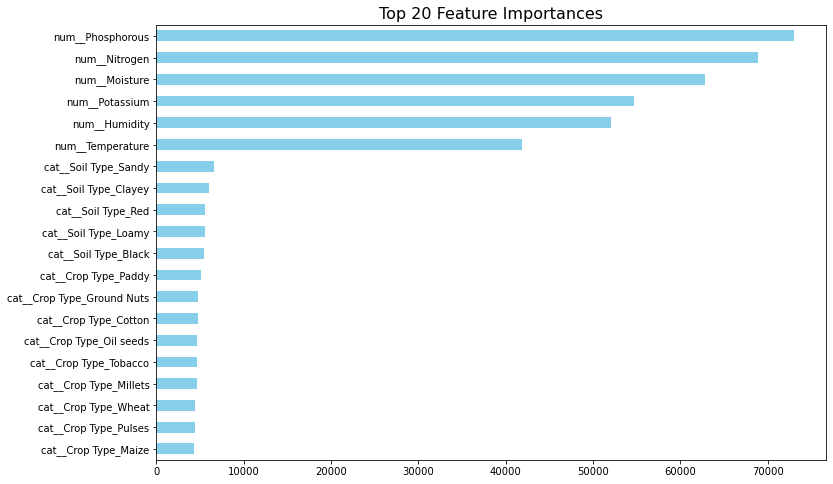

In [51]:
evl.plot_feature_importance(best_lgb, list(pof_df_proc.columns))

### LightGBM - Feature Importance Analysis

**Clear Feature Hierarchy:**
The feature importance plot for the LightGBM model reveals a distinct and intuitive hierarchy among the features. The model's decisions are overwhelmingly driven by the nutrient levels in the soil, followed by general environmental conditions, and then the specific categorical features.

**Key Observations:**
* **Nutrient Dominance:** The soil nutrient levels (`Phosphorous`, `Nitrogen`, `Potassium`) and `Moisture` are by far the most influential features, holding the top four spots. This logically aligns with the problem of recommending a fertilizer.
* **Environmental Factors:** General environmental conditions like `Humidity` and `Temperature` form a clear second tier of importance.
* **Categorical Power:** Among the one-hot encoded features, `Soil Type` variations (e.g., `cat__Soil Type_Sandy`) are collectively more important than `Crop Type` variations, suggesting that the physical nature of the soil is a stronger predictor than the crop itself in this baseline model.

**Actionable Insights for Feature Engineering:**
The model's heavy reliance on the absolute values of the NPK nutrients presents a clear opportunity. The next iteration of feature engineering should focus on creating **ratio-based features** (e.g., the N:P ratio, P:K ratio). These new features will explicitly describe the *balance* of nutrients, which is often more critical for fertilizer selection than the absolute levels alone and could provide a significant performance boost.

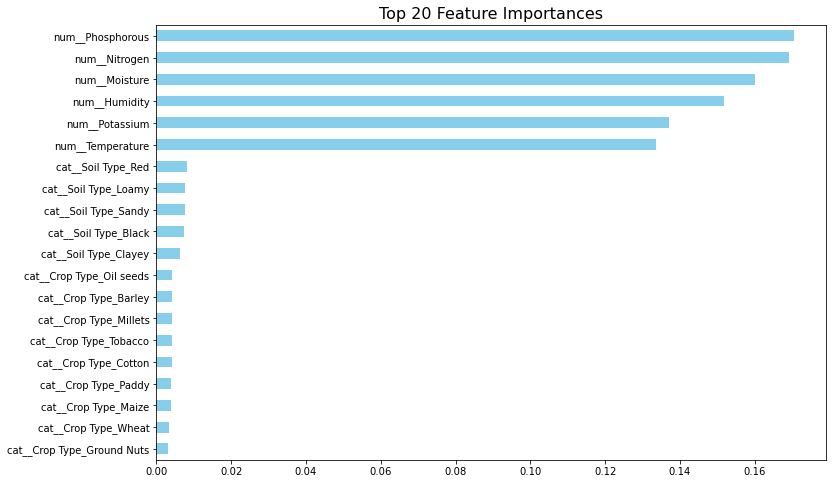

In [52]:
evl.plot_feature_importance(best_rf, list(pof_df_proc.columns))

### Random Forest - Feature Importance Analysis

**Overall Observations:**
Similar to the LightGBM model, the Random Forest (RF) model identifies the numerical features related to soil nutrients and environmental conditions as the most powerful predictors. The same top six features—`Phosphorous`, `Nitrogen`, `Moisture`, `Humidity`, `Potassium`, and `Temperature`—dominate the chart, confirming that these are the core drivers for this dataset, regardless of the model algorithm.

**Key Differences from LightGBM:**
A notable difference appears in how the models treat the categorical features. While the LightGBM model saw all `Soil Type` categories as having roughly similar moderate importance, the Random Forest model gives significantly higher importance to `cat__Soil Type_Red` compared to all other soil and crop types. This suggests the RF model may have identified specific patterns or rules related to "Red" soil that it heavily relies on. Furthermore, the importance values drop off more steeply after the top 6 features, indicating the RF model is focusing its decisions even more narrowly on this top tier of predictors.

**Combined Actionable Insights:**
The high level of agreement between both models on the top 6 features provides a very strong signal for the next round of feature engineering. The most promising path for model improvement is to create features that capture the complex interactions and relationships between these dominant variables.

1.  **Nutrient Ratios:** Creating features like `N_div_P` (Nitrogen to Phosphorous ratio) or `P_div_K` should be a top priority.
2.  **Interaction Features:** Given the differing importance of `Soil Type_Red`, creating specific interaction features (e.g., `Potassium * is_Soil_Type_Red`) could be a powerful way to provide a signal that some models might leverage more effectively than others.

This comparative analysis confirms our direction and gives us specific, data-driven hypotheses to test in the next iteration.